# TM10007 Assignment template

In [106]:
# Run this to use from colab environment
# %pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

In [107]:
# %pip install -U scikit-learn
# %pip install mlxtend

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [108]:
# Data loading functions. Uncomment the one you want to use
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from worcliver.load_data import load_data
from function_files.self_made import load_D_set, return_X_y, second_split, load_Tr_set, preprocessing, normalize_column, plt_lda, plt_tsne
from sklearn.covariance import EllipticEnvelope

df = load_data()

# Data clean-up (before splitting data)
In this section double entries, such as repeated features and samples, will be removed from the dataset.

In [109]:
'''
These 2 lines add a duplicate sample in the DataFrame, you can than observe what the effect is 
in the printed sentence. If you'd like to see it indeed works, please uncomment these lines.
'''
# row = df.iloc[0].copy()
# df = df.append(row, ignore_index=True)
'''
In the lines below we first drop all duplicate entries, whether it is a duplicate row or a column. 
Additionally, the number of duplicates will be returned to the user.
'''

df_f = df.drop_duplicates()
print(f'The number of samples (after removal of duplicates): {len(df_f.index)}, the number of duplicates that had to be removed: {len(df.index)-len(df_f.index)}')
print(f'The number of columns (after removal of duplicates): {len(df_f.columns)}, the number of duplicates that had to be removed: {len(df.columns)-len(df_f.columns)}')

The number of samples (after removal of duplicates): 186, the number of duplicates that had to be removed: 0
The number of columns (after removal of duplicates): 494, the number of duplicates that had to be removed: 0


In [110]:
df = df_f                                       # So we can just use df from now on
df = df.replace('', np.nan)                     # Any empty values are replaced for NaN
df.describe(include='all')                      # Uncomment if interested

non_numeric_columns = df.select_dtypes(exclude='number').columns.tolist()  # Label is a non_numeric_column
numeric_columns = df.select_dtypes(include='number').columns.tolist()
print(f'amount of nummeric features = {len(numeric_columns)}')  # All features are numeric_columns

amount of nummeric features = 493


### Conclusion
The table above shows there are only 2 labels present in the dataset, from observation of the csv.file we can see the labels are 'malignant' and 'benigne'. What is also stated here, that 94 of the 186 samples was labeled malignant (and thus 92 samples are labeled benigne.) This information is usefull in the next step, to determine whether a stratified splitting of our data, would be necessary.

# Data splitting
In this section the dataset will be split into two datasets, the Design set (D_set) and the Final Test set (Ft_set). This splitting will be performed randomly where 80% will end up in D_set and the remaining 20% will be stored in Ft_set. Ft_set will not be used at all, until the very latest to evaluate our tool and establish how generalising the tool is. In the initial split we will randomly split the dataset, as both labels are equally abundant in the set.

In [111]:
from sklearn.model_selection import train_test_split
# D_set, Ft_set = train_test_split(df, test_size=0.2)
# D_set = pd.DataFrame(D_set)
# Ft_set = pd.DataFrame(Ft_set)                         

Following lines were used to save the splitted sets, to make sure Design and Test set won't alter. 

In [112]:
# D_set.to_csv("C:/Users/dgjpa/D_set.csv")
# Ft_set = Ft_set.to_csv("C:/Users/dgjpa/Ft_set.csv")

In the lines below, we try to gain some insight in what information our Design dataset contains and how it looks like as a whole.

In [113]:
D_s = load_D_set()
D_s.head()


,label,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,PREDICT_original_sf_cvar_avg_2.5D,...,PREDICT_original_phasef_phasesym_median_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_peak_WL3_N5,PREDICT_original_phasef_phasesym_peak_position_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5
ID,,,,,,,,,,,,,,,,,,,,,
Liver-162_0,malignant,0.752802,0.067922,67.163862,11.220690,7.026174,3.458285,0.926487,0.039360,0.027479,...,0.0,0.104164,2.824183,8.300528,0.0,0,0.413396,2573.519080,0.003259,15.152812
Liver-107_0,malignant,0.863305,0.041397,20.226254,2.207196,5.627608,2.472796,0.971243,0.024797,0.014910,...,0.0,0.157725,1.443712,1.204595,0.0,0,0.540882,559.081045,0.197772,12.426019
Liver-027_0,malignant,0.848673,0.047620,48.683180,4.948065,5.176522,1.895492,0.957254,0.022640,0.010418,...,0.0,0.138953,1.599523,1.700270,0.0,0,0.486880,4299.321110,0.155208,15.656969
Liver-012_0,benign,0.851577,0.029381,27.900392,3.018271,3.801474,1.740597,0.959481,0.019448,0.012704,...,0.0,0.092495,3.278858,11.011162,0.0,0,0.384390,146.741591,0.000000,11.009890
Liver-028_0,malignant,0.860498,0.027800,24.229423,3.105308,7.590014,1.997398,0.981830,0.003572,0.017880,...,0.0,0.123031,2.372010,5.593998,0.0,0,0.471826,213.837686,0.066461,11.361561


In [114]:
D_s.describe(include='all')

,label,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,PREDICT_original_sf_cvar_avg_2.5D,...,PREDICT_original_phasef_phasesym_median_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_peak_WL3_N5,PREDICT_original_phasef_phasesym_peak_position_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5
count,148,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,...,148.000000,148.000000,148.000000,148.000000,148.0,148.0,148.000000,148.000000,148.000000,148.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,benign,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.810449,0.070357,31.025697,4.674168,8.464892,3.333409,0.958083,0.032232,0.026522,...,0.004139,0.118063,2.670400,10.224843,0.0,0.0,0.436461,845.910424,0.080586,12.147511
std,NaN,0.071607,0.048925,14.232578,2.753151,3.356987,2.270701,0.030172,0.032174,0.014970,...,0.019361,0.036251,1.599388,19.939644,0.0,0.0,0.111047,1283.408789,0.091892,1.962374
min,NaN,0.549046,0.004729,9.648695,1.130516,2.310309,0.265697,0.790738,0.003572,0.007132,...,0.000000,0.022161,0.517983,-0.850033,0.0,0.0,0.017016,4.299305,0.000000,6.264275
25%,NaN,0.774140,0.040098,20.157877,2.747720,6.380224,1.899252,0.951675,0.015465,0.015216,...,0.000000,0.095353,1.696290,2.123002,0.0,0.0,0.384490,137.177619,0.000000,10.744170
50%,NaN,0.825621,0.054622,27.523779,3.986081,7.914242,2.838249,0.963365,0.022517,0.023106,...,0.000000,0.116595,2.446979,5.836302,0.0,0.0,0.453225,323.948124,0.043008,12.154106
75%,NaN,0.860922,0.080052,38.818462,6.072275,10.175131,4.034999,0.976377,0.034812,0.032951,...,0.000000,0.139734,3.043456,9.470647,0.0,0.0,0.503929,987.265922,0.150151,13.631222


In [115]:
D_s.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148 entries, Liver-162_0 to Liver-008_0
Columns: 494 entries, label to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(468), int64(25), object(1)
memory usage: 572.3+ KB


Below, we have splitted the Design set into a dataframe including the label, and a dataframe including only the information without label. It can be observed that we have a total of 148 samples in our Design set with a total of 493 features.

In [116]:
D_s = load_D_set()
X_d, y_d = return_X_y(D_s)
X_d.shape, y_d.shape

((148, 493), (148, 1))

# Data splitting (2/2)
First, there will be two functions who return dataframes from the save .csv file. D_usable and Ft_usable are both DataFrames including both the labels as the feature information, and are the resulting datasets from the initial split as can be seen above.

X_d is a Dataframe including all the information about a case but with the labels removed, whereas y_d is a DataFrame including only the labels.

Also a second split is performed to ensure our preprocessing steps can be validated. The second split should result in a total of 44 files. A total of 11 pairs of validation (ca. 10%) and train sets (ca. 90%), which are consequently splitted into a .csv file containing only feature information (X_Tr/Va) and csv-files containing only the label per sample (y_Tr/Va).

In [117]:
# Split Design set into train and validation sets.
second_split(X_d, y_d)

44 Files have been created, in folder "datasets"


# Preprocessing
Now that we have splitted our data, we can continue with the preprocessing steps on our training set. It was previously observed there were some zero-variance features present in the Design set. These zero-variances will not contribute in differentiating between any of the sampels and therefore can be savely removed. However, non-zero but small variances are chosen not to be removed based only on their variance as even minor variances could have significant impact in the differentiation between maligne and benigne.

The function below will remove the columns with zero-variance and will return the names of the removed columns, the columns from this Dataframe will be used to remove the same columns in subsequent steps in our model. In other words, based on the zero-variance in specific columns in our training set, these features will not be considered in the validation and test sets as well.

Additionally, the non-zero-variance columns will be screened for fraction of zero or NaN entries. If a column consists of more than 75% or 50% of zero's or NaN's, respectively, the column will be removed. Also the names of the specific columns will be returned and used to remove the corresponding columns from validation and test sets as well.

This filtered dataset will be screened on containing a missing value (NaN), the missing value will be recplaced by the mean of the feature. This is done to improve the accuracy with complete data for analysis and reduce the bias. To first remove the columns with 50% NaN, the noise introduced by replacing the NaN value with the mean is tried to be reduced. Thereby it affects the distribution of the data. 

This dataset will also be screened on features containing zeros. 

In [118]:
X_tr1, y_tr1 = load_Tr_set(1)
X_tr1.shape, y_tr1.shape

((134, 493), (134, 1))

In [119]:
from my_functions_Dafne import preprocessing
X_filtered, features_zero_var, features_low_std_dev, features_zeros, features_nans = preprocessing(X_tr1) # X_filtered, dataframe containing only columns with a non-zero variance. Features_removed, dataframe containing the names of the removed features.

# DIT KAN MISSCHIEN BETER OOK IN EEN FUNCTIE, VAN DE VALIDATIE SET MOET DE NAN DUS OOK NOG VERVANGEN WORDEN IN MEAN VAN DEZE WAARDEN
check_for_nan = X_filtered.isnull().values.any()    # Checking whether the dataset contains of NaN
print(f'Are there NaN existing in the resting dataset?: {check_for_nan}')
if check_for_nan == True:
    X_filtered= X_filtered.fillna(df.mean(numeric_only=True))  # Replace missing values with mean of each feature

zero_count = (X_filtered == 0.0).sum(axis=0)  # Makes a list of the features containing zeros and counts them. 
features_zero = pd.concat([zero_count, X_filtered.mean(), X_filtered.std(), X_filtered[X_filtered !=0].mean(), X_filtered[X_filtered !=0].std()], axis=1)  # The mean and std will be shown of each feature that contains zero. These are calculated with and without the zeros.
features_zero.columns = ['zero_count', 'mean', 'std', 'mean_without_0', 'std_without_0']  # Added the names of the columns
features_zero = features_zero[features_zero['zero_count'] > 0]  # Only shows features that contains one or multiple zeros

print(features_zero)

Number of removed columns due to zero-variance: 19
Number of removed columns due to standard deviation < 0.1: 219
Number of removed non-zero-variance columns due to fraction zero > 80%: 3
Number of removed non-zero-variance columns due to fraction NaN > 50%:  0
Remaining number of features after preprocessing: 252
Are there NaN existing in the resting dataset?: False
                                                    zero_count       mean  \
PREDICT_original_tf_LBP_quartile_range_R8_P24               33   5.708955   
PREDICT_original_tf_LBP_quartile_range_R15_P36              94   4.880597   
PREDICT_original_phasef_monogenic_peak_WL3_N5                4  82.179701   
PREDICT_original_phasef_monogenic_peak_position...           4  22.955224   

                                                          std  mean_without_0  \
PREDICT_original_tf_LBP_quartile_range_R8_P24        5.887191        7.574257   
PREDICT_original_tf_LBP_quartile_range_R15_P36       9.905603       16.350000   
P

Thus a total of 30 features could be removed during the preprocessing step!

# Handeling of Outliers
We chose to replace outliers with the mean of the specific feature, this approach is commonly used an is known as "imputation". However it may not always be the best stategy. Replacing an outlier with the mean of the feature assumes that the feature has a normal distribution, which may not always be the case. Additionally, replacing an outlier with the mean can have the effect of reducing the variability in te data, which may negatively impact the performance of the model. 

In [120]:
# Handeling of outliers
means = X_filtered.mean()
stds = X_filtered.std()
threshold = 3
for feature in X_filtered.columns:

    # Calculate the lower and upper bounds for the feature
    lower_bound = means[feature] - (stds[feature] * threshold)
    upper_bound = means[feature] + (stds[feature] * threshold)

    # Replace outleirs with the feature mean
    X_filtered.loc[(X_filtered[feature] < lower_bound) | (X_filtered[feature] > upper_bound), feature] = means[feature]

### Scaling
To give every feature the same weight, all features should be scaled. We choose to do this by min-max scaling. 
Below you find the code to apply this normalization to each column of the dataframe.

In [121]:
import importlib
import my_functions_Dafne
importlib.reload(my_functions_Dafne)
from my_functions_Dafne import normalize_column, normalize_standard

X_tr_norm = X_filtered.apply(normalize_column)
X_tr_norm2 = X_filtered.apply(normalize_standard)

# # Create a box plot of the original data
# X_filtered.boxplot(figsize=(10,5))
# plt.title('Original Data')
# plt.show()

# # Create a box plot of the normalized data
# X_tr_norm.boxplot(figsize=(10,5))
# plt.title('Normalized Data')
# plt.show()

# X_tr_norm2.boxplot(figsize=(10,5))
# plt.title('Normalized Data 2')
# plt.show()


     PREDICT_original_sf_rad_dist_avg_2.5D  \
0                                 0.180872   
1                                 0.110094   
2                                 0.074204   
3                                 0.537668   
4                                 0.125241   
..                                     ...   
129                               0.149969   
130                               0.647572   
131                               0.437287   
132                               0.054800   
133                               0.484114   

     PREDICT_original_sf_rad_dist_std_2.5D  \
0                                 0.400522   
1                                 0.197359   
2                                 0.069896   
3                                 0.547964   
4                                 0.186851   
..                                     ...   
129                               0.094746   
130                               0.695674   
131                              

In order to use our data we need to transform the labels, and as we have only two labels this is easy and we chose to code benign as 0 and malignant as 1. Additionally we will have to transform both the X and the y Dataframes to a numpy array, in order to use scikit learn modules.

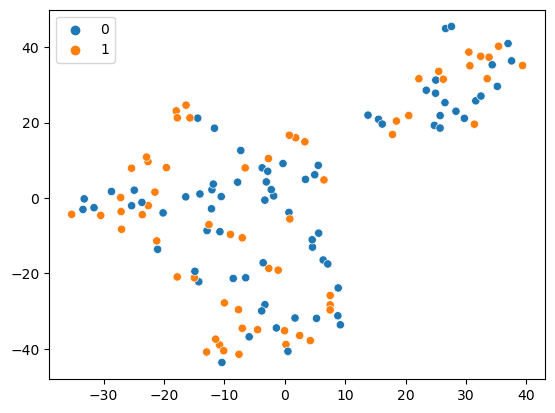

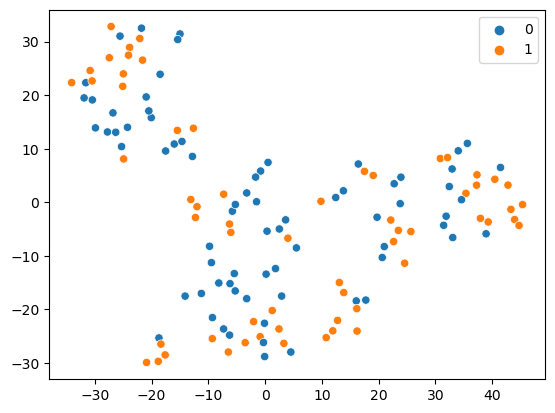

In [122]:
plt_tsne(X_tr_norm, y_tr1)
plt_tsne(X_tr_norm2, y_tr1)

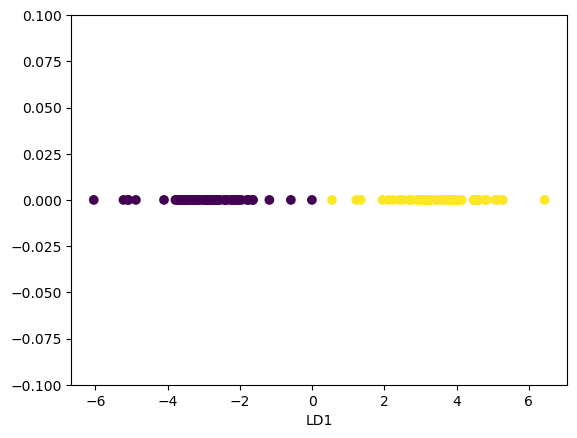

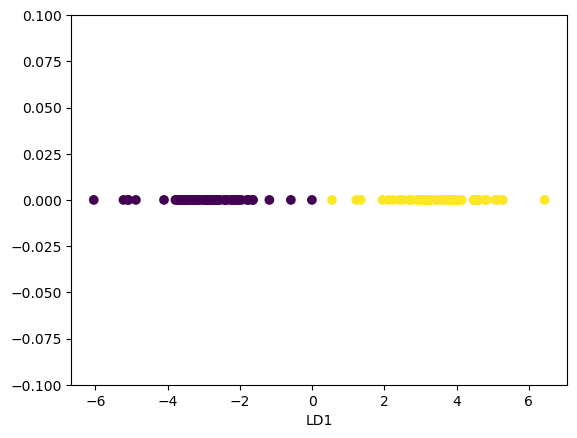

In [123]:
plt_lda(X_tr_norm, y_tr1)
plt_lda(X_tr_norm2, y_tr1)

# Feature selection


In [151]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# define the model
model = LogisticRegression(max_iter=1000)

# define the RFE method with n_features_to_select = 10
rfe = RFE(estimator=model, n_features_to_select=40)

# fit the RFE model to the data
rfe.fit(X_tr_norm2, y_tr1.reshape(-1,))

# get the selected features
selected_features = X_tr_norm2.columns[rfe.support_]

X_tr_norm2_selected = X_tr_norm2.loc[:, selected_features]

# X_tr_norm2_selected.boxplot(figsize=(10,5))
# plt.title('Normalised data scaled by standard scaling after feature selection by RFE')
# plt.show()

# fit the RFE model to the data
rfe.fit(X_tr_norm, y_tr1.reshape(-1,))

# get the selected features
selected_features = X_tr_norm.columns[rfe.support_]

X_tr_norm_selected = X_tr_norm.loc[:, selected_features]

# X_tr_norm_selected.boxplot(figsize=(10,5))
# plt.title('Normalised data scaled by MinMax scaling after feature selection by RFE')
# plt.show()